In [1]:
import os
import sys
import absl.logging
import PIL.Image

import numpy as np
import pandas as pd

from typing import Callable
from tensorflow import keras

module_path = os.path.abspath(os.path.join('..', '..', '..'))

if module_path not in sys.path:
    sys.path.append(os.path.join(module_path))

from functions.ciou import ciou_loss, ciou_metric
from functions.loading_data import SMALLER_HEIGHT, SMALLER_WIDTH
from functions.model_running import get_run_number, finalize_run

absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
get_names = lambda root_path: [
    file_name.split('.')[0]
    for dir_path, _, file_names in os.walk(root_path)
    for file_name in file_names
]
get_paths = lambda path: [f'{os.path.join(root, file)}' for root, dirs, files in os.walk(path) for file in files]
base_dir = os.path.join('..', '..', '..', '..', '..', 'data1', 'images_original_inception_resnet_v2_200x150_splitted')
train_dir = os.path.join(base_dir, 'training')
valid_dir = os.path.join(base_dir, 'validation')

In [3]:
def get_images_array(paths: list[str]) -> np.ndarray:
    rows = []
    rescale = keras.layers.Rescaling(1./255)

    for path in paths:
        with PIL.Image.open(path) as image:
            image_array = np.asarray(image)
            rescaled_image = rescale(image_array)
            rows.append(rescaled_image)

    return np.array(rows)


train_paths = get_paths(train_dir)
valid_paths = get_paths(valid_dir)
X_train = get_images_array(train_paths)
X_valid = get_images_array(valid_paths)

In [4]:
train_names = set(get_names(train_dir))
valid_names = set(get_names(valid_dir))
metadata_path = os.path.join('..', '..', '..', '..', '..', 'data1', 'HAM10000_metadata_ext.csv')
data = pd.read_csv(metadata_path).sort_values(by='image_id')
relevant_cols = ['top', 'left', 'bottom', 'right']
train_df = data[data['image_id'].isin(train_names)][relevant_cols]
valid_df = data[data['image_id'].isin(valid_names)][relevant_cols]
ys_train = train_df.to_numpy().astype(float)
ys_train[:, [0, 2]] /= SMALLER_HEIGHT
ys_train[:, [1, 3]] /= SMALLER_WIDTH
ys_valid = valid_df.to_numpy().astype(float)
ys_valid[:, [0, 2]] /= SMALLER_HEIGHT
ys_valid[:, [1, 3]] /= SMALLER_WIDTH

In [5]:
def get_branched_model(loss: Callable, metric: Callable) -> keras.Model:
    def get_branch_module(kernel_size: int) -> keras.layers.Layer:
        conv = keras.layers.Conv2D(16, kernel_size, padding='same', strides=2, activation='relu')(_input)
        conv = keras.layers.MaxPooling2D()(conv)

        return conv

    def get_stacked_conv(filters: int, prev: keras.layers.Layer) -> keras.layers.Layer:
        conv_module = keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(prev)
        conv_module = keras.layers.MaxPooling2D()(conv_module)
        conv_module = keras.layers.Dropout(.2)(conv_module)

        return conv_module

    _input = keras.layers.Input(shape=(SMALLER_HEIGHT, SMALLER_WIDTH, 3))
    conv1 = get_branch_module(3)
    conv2 = get_branch_module(5)
    conv3 = get_branch_module(7)
    merged = keras.layers.concatenate([conv1, conv2, conv3])
    conv_module = get_stacked_conv(64, merged)
    conv_module = get_stacked_conv(128, conv_module)
    conv_module = get_stacked_conv(256, conv_module)
    flat = keras.layers.Flatten()(conv_module)
    locator_module = keras.layers.Dense(256, activation='relu')(flat)
    locator_module = keras.layers.Dense(128, activation='relu')(locator_module)
    locator_module = keras.layers.Dense(4, activation='sigmoid')(locator_module)

    model = keras.Model(_input, locator_module)

    model.compile(optimizer='adam', loss=loss, metrics=[metric])

    print(model.summary())

    return model

In [6]:
def run_model(
        model_factory: Callable,
        model_name: str,
        loss: Callable,
        metric: Callable,
        reduction_patience=5,
        monitor='val_ciou_metric'):
    MIN_DELTA = .001
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=monitor,
        mode='max',
        patience=20,
        min_delta=MIN_DELTA)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor=monitor,
        mode='max',
        factor=0.95,
        min_delta=MIN_DELTA,
        patience=reduction_patience,
        min_lr=0.0005,
        verbose=1)
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath=os.path.join('..', '..', '..', '..', 'tmp_models', model_name + '_{epoch}'),
        save_best_only=True)
    tensor_board = keras.callbacks.TensorBoard(log_dir=os.path.join('..', '..', '..', '..', 'tensor_logs', model_name))
    model = model_factory(loss, metric)

    return model.fit(
        X_train,
        ys_train,
        validation_data=(X_valid, ys_valid),
        epochs=500,
        batch_size=64,
        callbacks=[reduce_lr, model_checkpoint, tensor_board, early_stopping])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 100, 16)  448         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 75, 100, 16)  1216        ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 75, 100, 16)  2368        ['input_1[0][0]']            

INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_1\assets


126/126 [==============================] - 10s 50ms/step - loss: 0.6274 - ciou_metric: 0.3732 - val_loss: 0.5630 - val_ciou_metric: 0.4374 - lr: 0.0010
Epoch 2/500
125/126 [============================>.] - ETA: 0s - loss: 0.4969 - ciou_metric: 0.5031INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_2\assets


INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_2\assets


126/126 [==============================] - 5s 42ms/step - loss: 0.4969 - ciou_metric: 0.5032 - val_loss: 0.5374 - val_ciou_metric: 0.4626 - lr: 0.0010
Epoch 3/500
126/126 [==============================] - ETA: 0s - loss: 0.4935 - ciou_metric: 0.5064INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_3\assets


INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_3\assets


126/126 [==============================] - 5s 42ms/step - loss: 0.4935 - ciou_metric: 0.5064 - val_loss: 0.5129 - val_ciou_metric: 0.4870 - lr: 0.0010
Epoch 4/500
126/126 [==============================] - ETA: 0s - loss: 0.4921 - ciou_metric: 0.5084INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_4\assets


INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_4\assets


126/126 [==============================] - 5s 43ms/step - loss: 0.4921 - ciou_metric: 0.5084 - val_loss: 0.4952 - val_ciou_metric: 0.5046 - lr: 0.0010
Epoch 5/500
124/126 [============================>.] - ETA: 0s - loss: 0.4921 - ciou_metric: 0.5079INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_5\assets


INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_5\assets


126/126 [==============================] - 5s 42ms/step - loss: 0.4917 - ciou_metric: 0.5086 - val_loss: 0.4948 - val_ciou_metric: 0.5049 - lr: 0.0010
Epoch 6/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4915 - ciou_metric: 0.5089 - val_loss: 0.4952 - val_ciou_metric: 0.5045 - lr: 0.0010
Epoch 7/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4930 - ciou_metric: 0.5068 - val_loss: 0.4967 - val_ciou_metric: 0.5032 - lr: 0.0010
Epoch 8/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4925 - ciou_metric: 0.5071 - val_loss: 0.4955 - val_ciou_metric: 0.5044 - lr: 0.0010
Epoch 9/500
126/126 [==============================] - ETA: 0s - loss: 0.4925 - ciou_metric: 0.5073
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_9\assets


INFO:tensorflow:Assets written to: ..\..\..\..\tmp_models\custom_models_3_branched_model_S_40_9\assets


126/126 [==============================] - 5s 43ms/step - loss: 0.4925 - ciou_metric: 0.5073 - val_loss: 0.4946 - val_ciou_metric: 0.5051 - lr: 0.0010
Epoch 10/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4914 - ciou_metric: 0.5090 - val_loss: 0.4951 - val_ciou_metric: 0.5047 - lr: 9.5000e-04
Epoch 11/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4914 - ciou_metric: 0.5088 - val_loss: 0.4949 - val_ciou_metric: 0.5049 - lr: 9.5000e-04
Epoch 12/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4921 - ciou_metric: 0.5081 - val_loss: 0.4950 - val_ciou_metric: 0.5047 - lr: 9.5000e-04
Epoch 13/500
126/126 [==============================] - 4s 31ms/step - loss: 0.4912 - ciou_metric: 0.5084 - val_loss: 0.4946 - val_ciou_metric: 0.5051 - lr: 9.5000e-04
Epoch 14/500
125/126 [============================>.] - ETA: 0s - loss: 0.4917 - ciou_metric: 0.5083
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0009025000152178108.

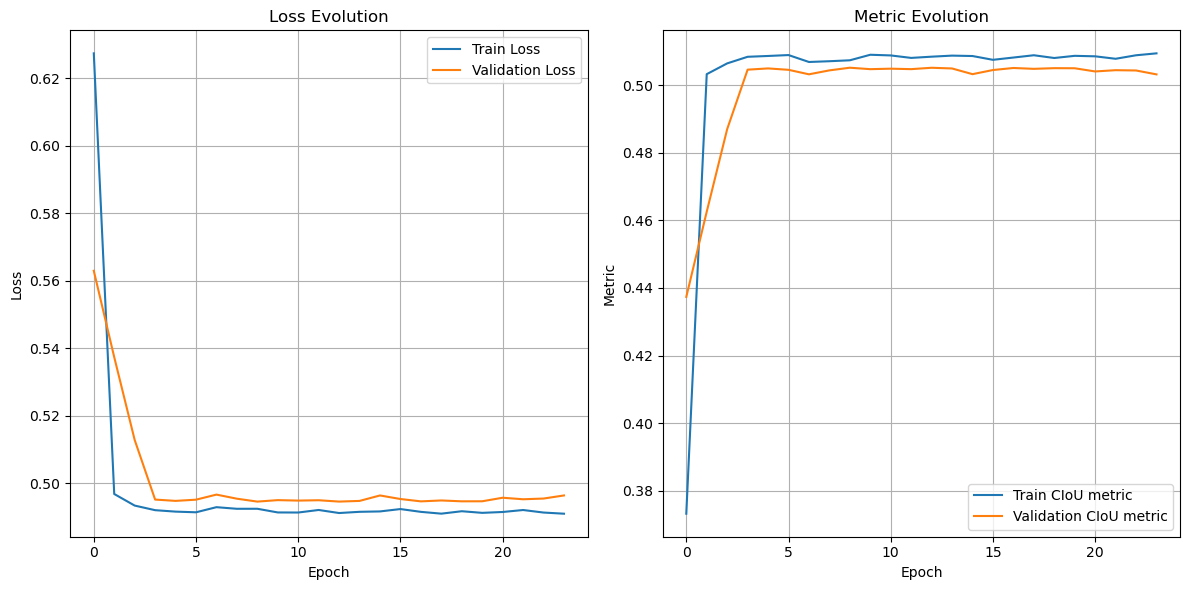

In [7]:
model_base_name = 'custom_models_3_branched_model_S'
run_number = get_run_number(model_base_name)
model_name = f'{model_base_name}_{run_number}'
history = run_model(get_branched_model, model_name, ciou_loss, ciou_metric)
ROOT = os.path.join('..', '..', '..', '..')
DS_NAME = 'data1_roi'
plot_name = f'{model_name}.pdf'

finalize_run(ROOT, plot_name, model_base_name, DS_NAME, history, plot_mode = 'multiple')